<h1>What's for dinenr?</h1>
<h4><i> An simple LSTM model generates dinner suggestions from partial ingredient list </i><h4>
<h4><br></h4>
<h2>Introduction</h2>


<h2>Data Cleaning</h2>
<h3> Ingredient Data </h3>

In [177]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle

import tensorflow as tf
import gensim.downloader as api
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer

import seaborn as sns
#from wordcloud import WordCloud

In [180]:
#precleaned dataframe will be used to clena data
precleaned_key = pd.read_pickle('ingr_map.pkl')
precleaned_key[['raw_ingr','replaced']]

,raw_ingr,replaced
0,"medium heads bibb or red leaf lettuce, washed,...",lettuce
1,mixed baby lettuces and spring greens,lettuce
2,romaine lettuce leaf,lettuce
3,iceberg lettuce leaf,lettuce
4,red romaine lettuce,lettuce
...,...,...
11654,soybeans,soybean
11655,goose,goose
11656,ajwain,ajwain
11657,brinjals,brinjal


In [182]:
cleaning_key = dict(zip(precleaned_key['raw_ingr'],precleaned_key['replaced']))

In [183]:
class CleanRecipes():
    def __init__(self,cleaning_key=cleaning_key): 
        self.raw_recipes = self.import_data()
        self.input_sequences = self.raw_recipes['ingredients'].apply(self.string_to_list).to_list()
        print(self.input_sequences)
        self.cleaned_ingredients = []
        self.cleaning_key = cleaning_key

    def __call__(self):
        self.cleaned_ingredients = self.clean_text()
        return self.raw_recipes, self.input_sequences, self.cleaned_ingredients

    def import_data(self):
        #'''Imporrhow to run a jupyter notebook in a gpu docker contqainert cleaned recipe, raw recipe and ratings data'''
        raw_recipes = pd.read_csv('RAW_recipes.csv')
        del raw_recipes['contributor_id']
        del raw_recipes['submitted']
        del raw_recipes['tags']
        del raw_recipes['steps']
        del raw_recipes['description']
        raw_recipes = raw_recipes.set_index('id')
        return raw_recipes

    def string_to_list(self,s):
        '''Converts a string that is formatted like a list to a list'''
        l = re.findall(r'\w[\w\s]+',s)
        return l

    def clean_text(self):
        #all_ingredients = [x for sublist in self.input_sequences for x in sublist]
        for recipe in self.input_sequences:
            ingredient_bundle = []
            for ingredient in recipe:
                try:
                    ingredient_bundle.append(self.cleaning_key[ingredient])
                except:
                    ingredient_bundle.append(ingredient)
            self.cleaned_ingredients.append(ingredient_bundle)
        return self.cleaned_ingredients

In [307]:
cleaner = CleanRecipes()
raw_recipes, input_sequences, cleaned_sequences = cleaner()
cleaned_sequences[1]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['pizza crust', 'sausage', 'egg', 'milk', 'salt and pepper', 'cheese']

In [302]:
#removing extra spaces
names = raw_recipes['name'].to_list()
def empty_check(s):
    if s != '':
        return True
    else: return False

cleaned_names = []
for name in names:
    cleaned_names.append(list(filter(empty_check,str(name).split(' '))))
    
print(names[:10])
cleaned_names[:10]

['arriba   baked winter squash mexican style', 'a bit different  breakfast pizza', 'all in the kitchen  chili', 'alouette  potatoes', 'amish  tomato ketchup  for canning', 'apple a day  milk shake', 'aww  marinated olives', 'backyard style  barbecued ribs', 'bananas 4 ice cream  pie', 'beat this  banana bread']


[['arriba', 'baked', 'winter', 'squash', 'mexican', 'style'],
 ['a', 'bit', 'different', 'breakfast', 'pizza'],
 ['all', 'in', 'the', 'kitchen', 'chili'],
 ['alouette', 'potatoes'],
 ['amish', 'tomato', 'ketchup', 'for', 'canning'],
 ['apple', 'a', 'day', 'milk', 'shake'],
 ['aww', 'marinated', 'olives'],
 ['backyard', 'style', 'barbecued', 'ribs'],
 ['bananas', '4', 'ice', 'cream', 'pie'],
 ['beat', 'this', 'banana', 'bread']]

<h2><br></h2>
<h2>EDA</h2>

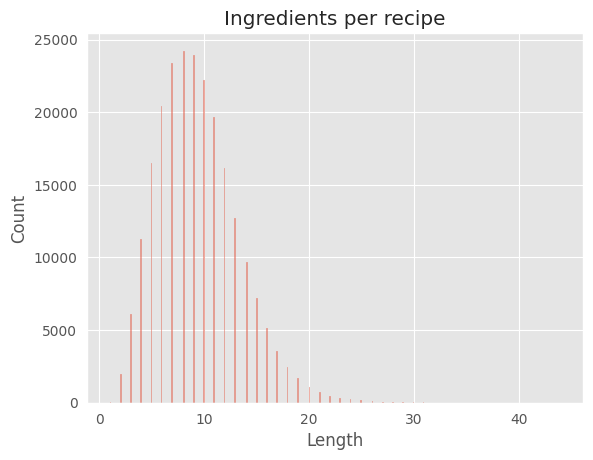

In [310]:
#ingredient list length
lengths = [len(x) for x in cleaned_sequences]
plt.style.use('ggplot')
sns.histplot(pd.DataFrame(lengths),legend=False)
plt.title('Ingredients per recipe')
plt.xlabel('Length')
plt.show()

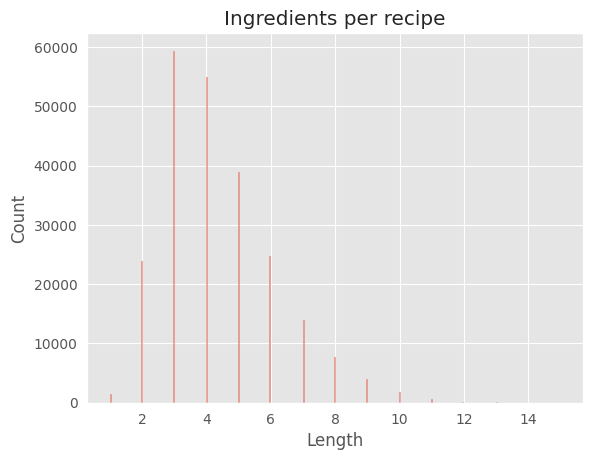

In [309]:
#Recipe name length
lengths = [len(x) for x in cleaned_names]
plt.style.use('ggplot')
sns.histplot(pd.DataFrame(lengths),legend=False)
plt.title('Words in a recipe name')
plt.xlabel('Length')
plt.show()

In [186]:
#overview of frequencies
'''
all_words = ' '.join([x for sublist in cleaned_sequences for x in sublist])
wordcloud = WordCloud().generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word frequencies');
'''

"\nall_words = ' '.join([x for sublist in cleaned_sequences for x in sublist])\nwordcloud = WordCloud().generate(all_words)\nplt.imshow(wordcloud, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word frequencies');\n"

In [187]:
#top words
def get_top(cleaned_sequences):
    ingred = [x for sublist in cleaned_sequences for x in sublist]
    ingred_counts = Counter(ingred).most_common()
    #top_ingredients = [ingred_counts[n][0] for n in range(len(ingred_counts))]
    return ingred_counts

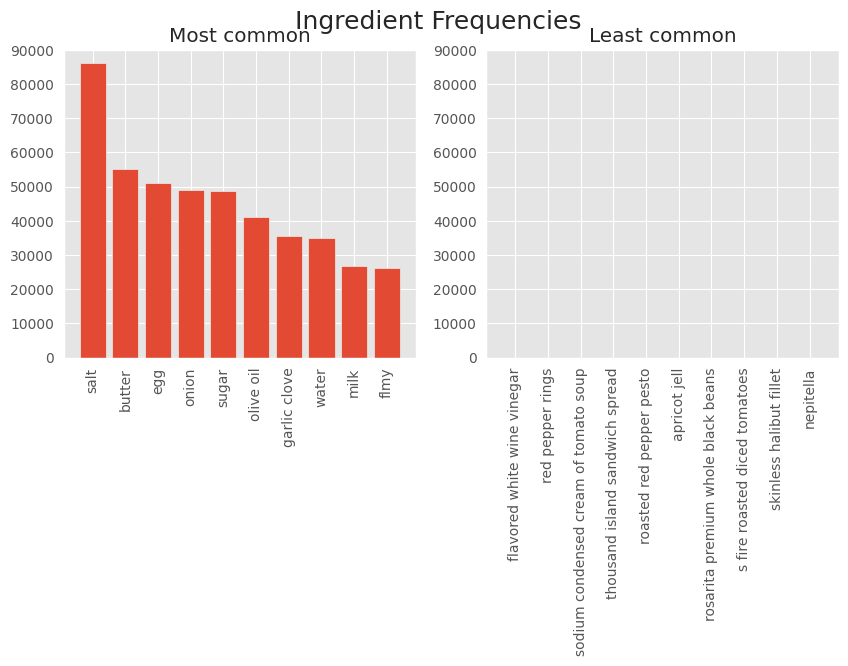

In [188]:
tops = get_top(cleaned_sequences)
sorted_ingredients = [x[0] for x in tops]
sorted_counts = [x[1] for x in tops]

count_range = 10 
plt.figure(figsize=(10,4))
plt.style.use('ggplot')
plt.suptitle('Ingredient Frequencies',fontsize=18)
plt.subplot(1,2,1)
plt.bar(sorted_ingredients[:count_range], sorted_counts[:count_range])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Most common')

plt.subplot(1,2,2)
plt.bar(sorted_ingredients[-count_range:], sorted_counts[-count_range:])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Least common');

<h2><br></h2>
<h2>Tokenizing ingredients</h2>

In [189]:
pad_value = int(0)

In [190]:
class TokenizeRecipes():
    def __init__(self, input_sequences):
        self.tokenizer = Tokenizer()
        self.input_sequences = input_sequences
    
    def __call__(self):
        self.tokenizer, self.ngram_sequences, self.totalwords = self.get_sequence_of_tokens()
        self.max_length = self.find_max()
        self.padded_sequence = self.pad_sequences()
        self.padded_sequence = np.array(self.padded_sequence)
        self.predictors, self.label = self.padded_sequence[:,:-1],self.padded_sequence[:,-1]
        return self.tokenizer, self.max_length, self.totalwords, self.label, self.predictors

    def get_sequence_of_tokens(self):
        '''Tokenization'''    
        self.tokenizer.fit_on_texts(self.input_sequences)
        self.total_words = len(self.tokenizer.word_index) + 1

        self.ngram_sequences = []
        for line in self.input_sequences:
            token_list = self.tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                self.ngram_sequences.append(n_gram_sequence)
        return self.tokenizer, self.ngram_sequences, self.total_words

    def find_max(self):
        '''find max token length'''
        self.max_length = max(len(x) for x in self.input_sequences)
        return self.max_length

    def pad_sequences(self):
        '''pad sequences (built in function returns a recursion error)'''
        self.padded_sequence = []
        for sequence_in in self.ngram_sequences:
            zeros = (self.max_length-len(sequence_in))
            padded = [pad_value for zero in range(zeros)]
            padded.extend(sequence_in)
            self.padded_sequence.append(padded)
        return self.padded_sequence

In [191]:
tokenizer,max_length,total_words,label,predictors = TokenizeRecipes(cleaned_sequences)()
total_words

12413

In [192]:
max_length

44

Embedding words using word2vec

In [193]:
api.info(name_only=True)

{'corpora': ['semeval-2016-2017-task3-subtaskBC',
  'semeval-2016-2017-task3-subtaskA-unannotated',
  'patent-2017',
  'quora-duplicate-questions',
  'wiki-english-20171001',
  'text8',
  'fake-news',
  '20-newsgroups',
  '__testing_matrix-synopsis',
  '__testing_multipart-matrix-synopsis'],
 'models': ['fasttext-wiki-news-subwords-300',
  'conceptnet-numberbatch-17-06-300',
  'word2vec-ruscorpora-300',
  'word2vec-google-news-300',
  'glove-wiki-gigaword-50',
  'glove-wiki-gigaword-100',
  'glove-wiki-gigaword-200',
  'glove-wiki-gigaword-300',
  'glove-twitter-25',
  'glove-twitter-50',
  'glove-twitter-100',
  'glove-twitter-200',
  '__testing_word2vec-matrix-synopsis']}

In [194]:
all_sequences = [x for list1 in cleaned_sequences for x in list1]

In [195]:
embed_model = api.load('word2vec-google-news-300')

In [196]:
embed_size = 300

In [197]:
def embed_one_ingredient(ingredient):
    '''Encode a single recipe'''
    recipe_embedding = []
    try:
        recipe_embedding.append(embed_model[ingredient])
    except:
        recipe_embedding.append(np.zeros((embed_size)))
    #recipe_embedding = pd.DataFrame(recipe_embedding)
    return recipe_embedding

In [198]:
test_word = cleaned_sequences[:1][0][3]
test_word

'honey'

In [199]:
embed_one_ingredient(test_word)

[array([-4.54711914e-03, -1.25976562e-01, -1.68945312e-01,  6.17675781e-02,
         1.94549561e-03,  2.57568359e-02, -9.52148438e-02, -3.39843750e-01,
        -6.53076172e-03,  1.54296875e-01,  3.88183594e-02, -3.12500000e-01,
        -3.04687500e-01,  2.23632812e-01, -1.61132812e-01,  2.15820312e-01,
        -3.02734375e-01,  1.63085938e-01, -2.73437500e-01, -2.10937500e-01,
        -2.50244141e-02,  8.00781250e-02,  1.82617188e-01, -2.51464844e-02,
        -1.61132812e-01,  5.32226562e-02, -4.68750000e-02, -3.01513672e-02,
        -2.24609375e-02, -4.15039062e-02, -2.16064453e-02, -1.03027344e-01,
        -1.22680664e-02, -1.12792969e-01, -3.28125000e-01,  1.18164062e-01,
         1.76757812e-01, -1.90429688e-01,  2.51953125e-01,  2.20703125e-01,
         1.66992188e-01, -1.87500000e-01,  1.62109375e-01,  4.34570312e-02,
        -3.51562500e-01, -2.92968750e-01, -7.86132812e-02,  8.34960938e-02,
        -5.27954102e-03, -6.68945312e-02, -2.98828125e-01,  2.81250000e-01,
        -9.8

In [200]:
def find_unique_ingredients(cleaned_sequences):
    return list(set([x for sublist in cleaned_sequences for x in sublist]))

unique_ingredients = find_unique_ingredients(cleaned_sequences)

In [201]:
def encode_recipes(unique_ingredients,tokenizer=tokenizer,embed_size=embed_size):
    '''Encode all recipes'''
    word_index = tokenizer.word_index
    recipe_embeddings = np.zeros((len(unique_ingredients)+1,embed_size))
    for ingredient,i in word_index.items():
        ingredient_embedding = embed_one_ingredient(ingredient)[0]
        recipe_embeddings[i,:] = ingredient_embedding
    #recipe_embeddings = np.delete(recipe_embeddings,0,axis=0) #dict starts at 1
    return recipe_embeddings

recipe_embeddings = encode_recipes(unique_ingredients)
print(recipe_embeddings.shape)
pd.DataFrame(recipe_embeddings).head()

(12413, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.057373,0.222656,0.204102,0.046631,-0.027344,0.296875,-0.102539,-0.172852,0.024414,0.310547,...,-0.357422,-0.478516,-0.131836,0.162109,0.167969,0.054199,0.166016,0.197266,-0.053955,-0.161133
2,0.078125,0.203125,0.063965,0.133789,0.096191,0.004486,0.271484,-0.421875,-0.165039,0.183594,...,-0.179688,-0.320312,-0.150391,-0.000462,0.057617,-0.186523,0.121582,-0.072266,-0.140625,-0.132812
3,-0.349609,0.076172,0.095215,0.068359,-0.054199,0.023682,0.211914,-0.104492,-0.068359,0.234375,...,-0.150391,0.059814,-0.316406,0.023926,0.125977,-0.023438,0.046143,0.089355,-0.212891,0.118164
4,-0.255859,0.170898,-0.065918,0.213867,-0.040283,0.001259,0.304688,-0.202148,-0.190430,0.171875,...,-0.194336,-0.255859,0.318359,0.044678,0.333984,0.048584,-0.061523,0.125977,0.204102,0.382812


In [202]:
#preparing test and train sets

In [203]:
#shuffeling labels and predictors 
shuffled_index = np.random.permutation(len(predictors))
predictors = predictors[shuffled_index]
label = label[shuffled_index]

In [204]:
label

array([  24,   24,    1, ..., 2573,    6,   37])

In [205]:
predictors.max(), predictors.min()

(12412, 0)

In [206]:
predictors

array([[   0,    0,    0, ...,    0,  895,  161],
       [   0,    0,    0, ...,    0,    0,  300],
       [   0,    0,    0, ...,    0, 1163, 1532],
       ...,
       [   0,    0,    0, ...,  268,  197,   56],
       [   0,    0,    0, ...,    0,    0,   20],
       [   0,    0,    0, ...,  156,   42,  279]])

<h2><br></h2>
<h2>Building model to suggest ingredients</h2>

In [207]:
predictors.shape, label.shape, recipe_embeddings.shape,len(unique_ingredients)

((1948345, 43), (1948345,), (12413, 300), 12412)

In [208]:
predictors = tf.cast(predictors,tf.float64)
label = tf.cast(label,tf.float64)

In [209]:
checkpoint_filepath = '/tmp/checkpoint'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=5)

In [210]:
def create_model(embed_size=embed_size, unique_ingredients=len(unique_ingredients), recipe_embeddings=recipe_embeddings,lr=0.001,transfer=False):
    '''Build LSTM model'''
    input_len = max_length-1
    model = Sequential()
    model.add(Embedding(unique_ingredients+1, embed_size, weights=[recipe_embeddings], trainable=transfer, mask_zero=True, input_length=input_len)) 
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(unique_ingredients+1, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    return model

In [211]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [212]:
#run on cpu because gpu has glitch with mask_zero=True
'''
with tf.device('/cpu:0'):
    model = create_model()
    history = model.fit(predictors, label, validation_split=.1,epochs=50, callbacks=[save_callback, early_callback])
'''

"\nwith tf.device('/cpu:0'):\n    model = create_model()\n    history = model.fit(predictors, label, validation_split=.1,epochs=50, callbacks=[save_callback, early_callback])\n"

In [213]:
'''
with tf.device('/cpu:0'):
    model = create_model(lr=0.0001,transfer=True)
    model.load_weights(checkpoint_filepath)
    fine_history = model.fit(predictors, label, validation_split=.1, epochs=50,callbacks=[early_callback])
    #model.save_weights('./weights.h5')
'''

"\nwith tf.device('/cpu:0'):\n    model = create_model(lr=0.0001,transfer=True)\n    model.load_weights(checkpoint_filepath)\n    fine_history = model.fit(predictors, label, validation_split=.1, epochs=50,callbacks=[early_callback])\n    #model.save_weights('./weights.h5')\n"

In [214]:
'''
with open('histories.pkl','wb') as f:
    pickle.dump([history.history,fine_history.history],f)
f.close()
'''

"\nwith open('histories.pkl','wb') as f:\n    pickle.dump([history.history,fine_history.history],f)\nf.close()\n"

In [215]:
with open('histories.pkl','rb') as f:
    _ = pickle.load(f)
    history = _[0]
    fine_history = _[1]
f.close()

17 17


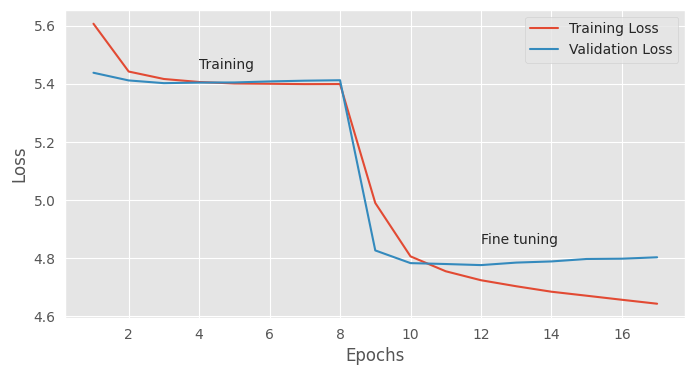

In [216]:
def plot_history(history_, fine_history_):
    epochs_train = len(history_['loss'])
    history_['loss'].extend(fine_history_['loss'])
    history_['val_loss'].extend(fine_history_['val_loss'])
    epochs_ft = len(history_['loss'])
    print(len(history_['loss']),epochs_ft)
 
    count = 1
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 4))   
    plt.plot(range(1,epochs_ft+1), pd.DataFrame(history_['loss']), label='Training Loss')
    plt.plot(range(1,epochs_ft+1), pd.DataFrame(history_['val_loss']), label='Validation Loss')
    plt.legend()
    plt.text(4,5.45,'Training')
    plt.text(12,4.85,'Fine tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
plot_history(history,fine_history)

<h2><br></h2>
<h2>Predicting what's for dinner</h2>

In [217]:
def pad_sequences(token_list, max_length=max_length):
    '''pad sequences (built in function returns a recursion error)'''
    padded_sequence = []
    zeros = (max_length-len(token_list))-1
    padded = [int(0) for zero in range(zeros)]
    padded.extend(token_list)
    return padded

In [218]:
def cook_for_me(seed_text, model):
    next_words = 5
    words_out = []
    token_list = []

    seed_text = seed_text.split(' ')
    for word in seed_text:
        token_ = tokenizer.texts_to_sequences([word])[0]
        token_list.extend(token_)
    token_list = pad_sequences(token_list)
        
    while next_words > 0:
        model.load_weights('weights.h5')
        proba = model.predict(np.array(token_list).reshape(-1,43), verbose=0)
        predicted = np.argmax(proba, axis=1)
        new_token = int(predicted[0])
        word = list(tokenizer.word_index.keys())[int(predicted[0]-1)]
        words_out.append(word)
        token_list.append(new_token)
        token_list.pop(0)
        next_words -= 1
    words_out = list(set(words_out))
    string_out = 'Why not try adding some '+', '.join(words_out[:-1])+' and '+words_out[-1]+'?'
    return string_out

In [219]:
def make_suggestions(ingredients_in_stock):
    for ingredient in ingredients_in_stock:
        split_ingredients = ' and '.join(ingredient.split(' '))
        greeting = 'For '+split_ingredients.upper() +' let me see... '
        print(greeting)
        print(cook_for_me(ingredient,model))
        print('')

In [220]:
ingredients_in_stock = ['tuna','chicken noodle','mirin','cherry','chocolate flour','lettuce']
make_suggestions(ingredients_in_stock)

For TUNA let me see... 
Why not try adding some mayonnaise, pickle, celery and onion?

For CHICKEN AND NOODLE let me see... 
Why not try adding some garlic clove, onion, carrot, celery and olive oil?

For MIRIN let me see... 
Why not try adding some sesame oil, garlic clove, soy sauce, sugar and fresh ginger?

For CHERRY let me see... 
Why not try adding some cornstarch, lemon juice, water and sugar?

For CHOCOLATE AND FLOUR let me see... 
Why not try adding some baking powder, sugar, butter, egg and flmy?

For LETTUCE let me see... 
Why not try adding some tomato, salt, cucumber, dressing and red onion?
